In [11]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from scipy import sparse
from scipy import integrate
from scipy.interpolate import CubicSpline
from scipy.sparse import linalg
import concurrent.futures
from skimage import transform

# System generation
We define the pCT system as a linear system as followed:
$$
    A x = b,
$$
while the matrix $A \in \mathbb{R}^{N \times M}$ contains on each row a unique Most Likely Path of shape $M = I \times J$ for each traversing proton of amount $N$, $b \in \mathbb{R}^N$ represents the Water Equvalent Path Length of each proton and $x \in \mathbb{R}^{I \times J}$ models the Residual Stopping Power of the phantom. 

In [34]:
rsp = np.load('../../Data/simple_pCT/Phantoms/Head/RSP.npy')

# padding is necessary
scale = 1
phantom = np.pad(rsp[:,:,rsp.shape[2]//2], ((30*scale,30*scale), (100*scale, 100*scale)))

x = phantom.flatten()
RSP_shape = phantom.shape[:2]
print(RSP_shape)

(190, 1226)


# System matrix A

In [23]:
def get_mlp(spline, phi, spotx=0, shape=(130, 1026), chord_length=True):
    MLP_prototype = sparse.lil_matrix(shape)
    
    rotation = np.array([
        [np.cos(-phi), -np.sin(-phi)],
        [np.sin(-phi), np.cos(-phi)]
    ]).T
      
    z_start = -81
    dz = ( 2 * 81 )/shape[1]/2
    box_edge = 96 # x direction
    
    # draw the spline
    i = np.arange(-600,shape[1]+1600)
    z_mlp = i * dz + z_start
    x_mlp = spline(z_mlp)
    # rotate
    point_mlp = (rotation @ np.array([z_mlp, x_mlp])).T
    
    i_rotated = np.int64((point_mlp[:,0] - z_start) / dz/2)
    j_rotated = np.int64((point_mlp[:,1] + box_edge) * shape[0] / (2 * box_edge) )
    
    valid_i = (i_rotated >= 0) & (i_rotated < shape[1])
    valid_j = (j_rotated >= 0) & (j_rotated < shape[0])
    
    valid = valid_i & valid_j
    
    MLP_prototype[ j_rotated[valid], i_rotated[valid] ] = 1
            
    if chord_length:
        points = np.array([z_mlp[valid], x_mlp[valid]]).transpose()
        dx_dz = spline(points[:,0], 1)
        
        length = np.sqrt( dz**2 + dx_dz**2).sum()
                
        return MLP_prototype / length
    else:
        return MLP_prototype
    
    
@widgets.interact(offset=(-50,50,1), phi=(-180,180,1), spotx=(-95,95,1))
def show_beam(offset=15, phi=-51, spotx=0):
    points = np.array([
        [-500,spotx], # beam source
        [-400,spotx],
        [-300,spotx],
        [-200,spotx],
        [-100,spotx],
        [-81,spotx], # enter phantom

        [81, offset + spotx] # leave phantom
    ])
    
    phi *= -np.pi/180
    
    rotation = np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)]
    ]).T

    cube = np.array([
        [-81,-96],
        [-81,96],
        [81,96],
        [81,-96],
        [-81,-96]
    ]).T
    
    cube = (rotation @ cube).T

    cs = CubicSpline(points[:,0], points[:,1])
    tangent = cs(81, 1)
    print('sensor hit: x =', tangent * (277-81) + cs(81))
    
    
    MLP_prototype = get_mlp(cs, phi, spotx, shape=RSP_shape)
    
    z = np.linspace(-500,81)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Overview')
    plt.plot(cube[:,0], cube[:,1], 'k', lw=2)
    plt.plot([277, 277], [-82, 82], c='orange', lw=2)
    plt.plot(z, cs(z), c='tab:red', ls='dashed')
    plt.plot(np.linspace(81, 277), tangent * np.linspace(0,277-81) + cs(81), c='tab:red', ls='dashed')
    plt.grid()
    plt.xlabel('z')
    plt.ylabel('x')
    plt.subplot(1,2,2)
    plt.title('MLP')
    plt.spy(MLP_prototype.toarray(), aspect='auto', origin='lower')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=15, description='offset', max=50, min=-50), IntSlider(value=-51, descrip…

In [35]:
num_angle = 179
num_offset = 1
num_spotx = 190
chord_length = True
print(num_angle, num_offset, num_spotx)

179 1 190


In [36]:
def worker_spotx_future(idx, cs, phi, spotx, target_shape, chord_length):
    return get_mlp(cs, phi, spotx, shape=target_shape, chord_length=chord_length).reshape((1,-1))

In [37]:
target_shape = RSP_shape

angles = -np.linspace(0,180,num_angle) * np.pi / 180
if num_offset == 1:
    offsets = [0]
else:
    offsets = np.linspace(-15, 15, num_offset)
spotxs = np.linspace(-95, 95, num_spotx)

MLP_angles_offsets_spotx = sparse.lil_matrix((len(angles) * len(offsets) * len(spotxs), np.prod(target_shape)))

future_to_idx = {}
with concurrent.futures.ThreadPoolExecutor(max_workers = 32) as executor:
    for odx,spotx in enumerate(spotxs):
        for xdx, offset in enumerate(offsets):
        
            points = np.array([
                [-500,spotx], # beam source
                [-400,spotx],
                [-300,spotx],
                [-200,spotx],
                [-100,spotx],
                [-81,spotx], # enter phantom

                [81,offset + spotx] # leave phantom
            ])

            cs = CubicSpline(points[:,0], points[:,1])

            for adx,phi in enumerate(angles):
                idx = odx * len(angles)*len(offsets) + xdx * len(angles) + adx

                future = executor.submit(worker_spotx_future, idx, cs, phi, spotx, target_shape, chord_length)
                future_to_idx[future] = idx
            
for future in concurrent.futures.as_completed(future_to_idx):
    idx = future_to_idx[future]
    try:
        MLP_angles_offsets_spotx[idx,:] = future.result()
    except Exception as exc:
            print('%r generated an exception: %s' % (idx, exc))

In [38]:
if chord_length:
    sparse.save_npz('../../Data/simple_pCT/MLP/MLP_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npz'.format(num_angle, num_offset, num_spotx, target_shape[0], target_shape[1]), MLP_angles_offsets_spotx.tocsc())
    print('MLP_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npz'.format(num_angle, num_offset, num_spotx, target_shape[0], target_shape[1]))
else:
    sparse.save_npz('MLP_angles{:d}_offset{:d}_spotx{:d}_map_{:d}_{:d}.npz'.format(num_angle, num_offset, num_spotx, target_shape[0], target_shape[1]), MLP_angles_offsets_spotx.tocsc())
    print('MLP_angles{:d}_offset{:d}_spotx{:d}_map_{:d}_{:d}.npz'.format(num_angle, num_offset, num_spotx, target_shape[0], target_shape[1]))

MLP_angles179_offset1_spotx190_exact_190_1226.npz


In [39]:
b_w = MLP_angles_offsets_spotx @ x
b_w_shaped = b_w.reshape((num_spotx, num_angle))
print(b_w_shaped.shape)

(190, 179)


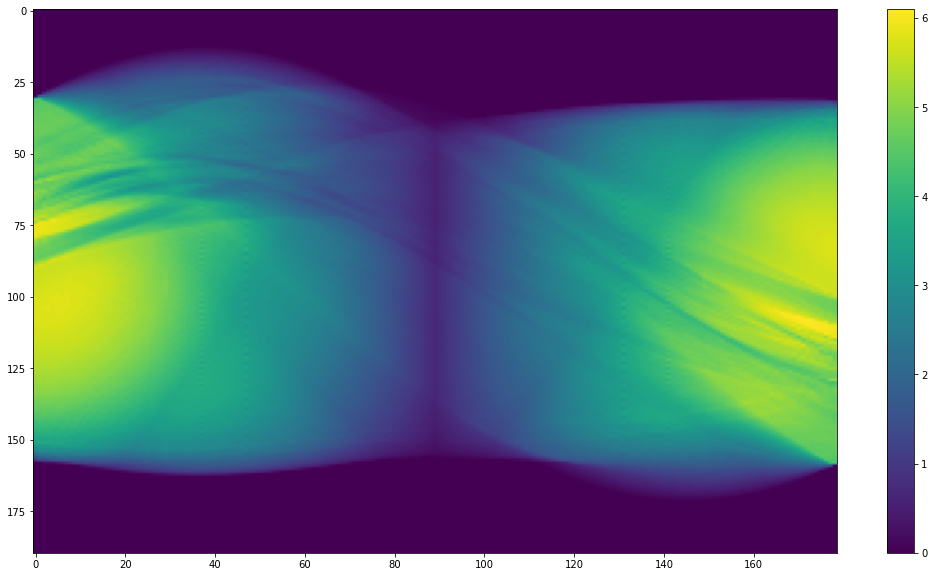

In [40]:
plt.figure(figsize=(18,10))
plt.imshow(b_w_shaped, aspect='auto')
plt.colorbar()
plt.show()

In [41]:
np.save('../../Data/simple_pCT/WEPL/WEPL_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, RSP_shape[0], RSP_shape[1]), b_w_shaped)

In [5]:
b_w_shaped = np.load('../../Data/simple_pCT/WEPL/WEPL_angles{:d}_offset{:d}_spotx{:d}_exact_{:d}_{:d}.npy'.format(num_angle, num_offset, num_spotx, RSP_shape[0], RSP_shape[1]))

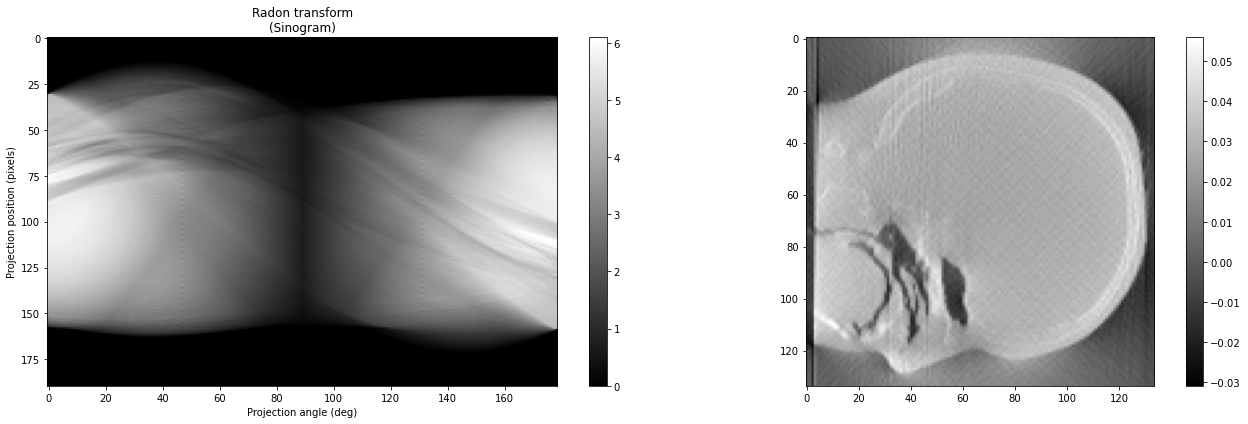

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

theta = np.linspace(0., 180., num_angle, endpoint=False)
ax1.set_title('Radon transform\n(Sinogram)')
ax1.set_xlabel('Projection angle (deg)')
ax1.set_ylabel('Projection position (pixels)')
sin = ax1.imshow(b_w_shaped, cmap='gray', aspect='auto')

plt.colorbar(sin, ax=ax1)

reconstructed = transform.iradon(b_w_shaped, theta=theta, filter_name='ramp', circle=False)
re = ax2.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax2)

fig.tight_layout()
plt.show()